In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
H = 400
W = 400
f = 1200

In [10]:
rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)


In [11]:
u

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [12]:
u.shape

(400,)

In [13]:
u, v = np.meshgrid(u, v)


In [16]:
u.shape

(400, 400)

In [17]:
print(u)

[[  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]
 ...
 [  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]]


In [19]:
dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)

# this is basically the camera matrix
# dirs is the direction of the camera in the world frame
# dirs = np.stack((x, y, z), axis=-1) is same as above but in the camera frame



In [20]:
dirs.shape

(400, 400, 3)

In [21]:
dirs[0]

array([[ -200.,   200., -1200.],
       [ -199.,   200., -1200.],
       [ -198.,   200., -1200.],
       ...,
       [  197.,   200., -1200.],
       [  198.,   200., -1200.],
       [  199.,   200., -1200.]])

In [22]:
rays_d = dirs / np.linalg.norm(dirs, axis=-1)
rays_d.shape

ValueError: operands could not be broadcast together with shapes (400,400,3) (400,400) 

In [23]:
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d.shape

(400, 400, 3)

In [24]:
rays_d = rays_d.reshape(-1, 3)

In [25]:
rays_d.shape

(160000, 3)

In [32]:
def plot_rays(o, d, t):
    
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    
    pt1 = o #origin
    pt2 = o + t * d # it is where the vector is after time t. or it is the end point of the ray in the world frame
    # or pt2 = o + d # it is also the direction of the ray in the world frame
    for p1, p2 in zip(pt1[::100], pt2[::100]):
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
    
    
    plt.show()

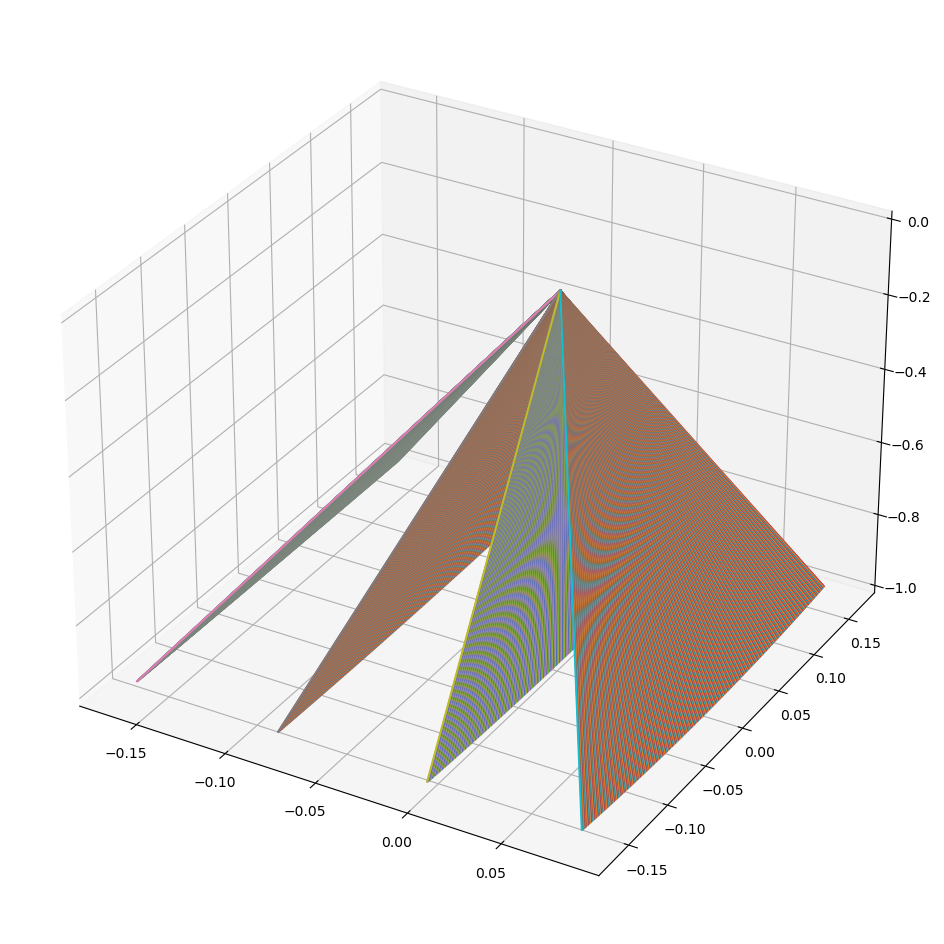

In [33]:
plot_rays(rays_o, rays_d, 1)

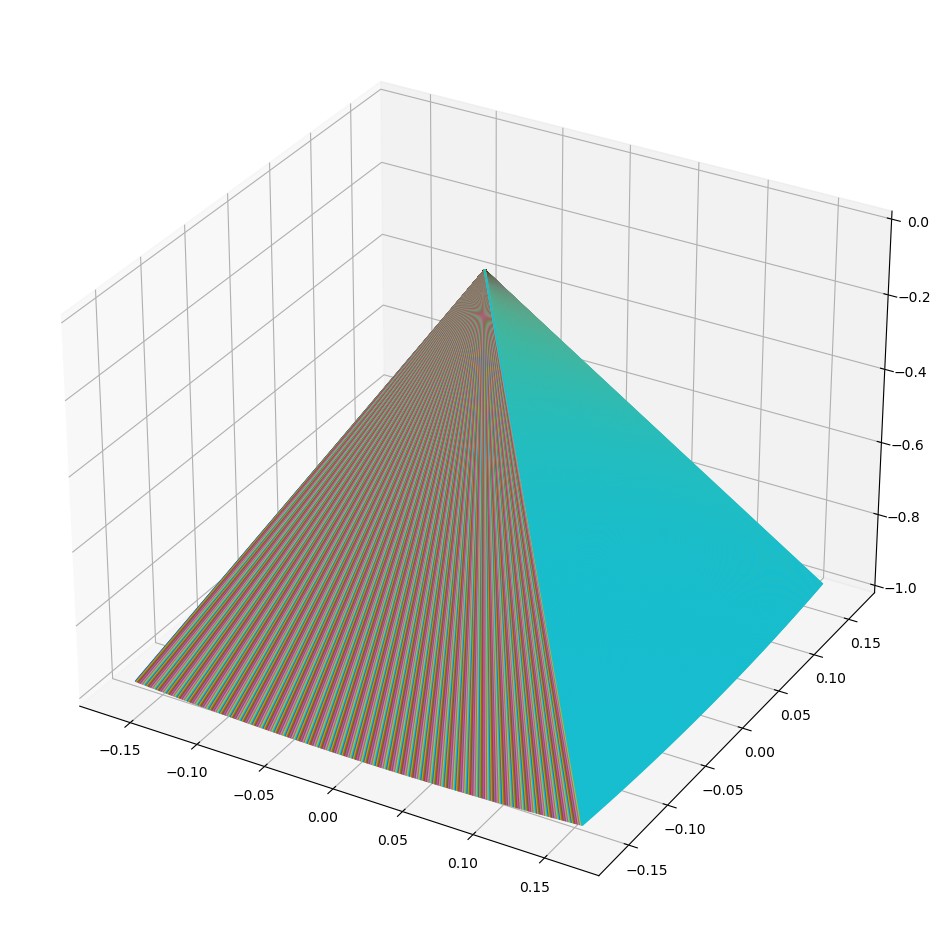

In [29]:
plot_rays(rays_o, rays_d, 1) 

# Rendering the image

In [34]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\mrmoh\anaconda3\envs\Nerf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
o = torch.tensor([0., 0., 1.])

H = 400
W = 400
focal_length = 1200

u, v = np.meshgrid(np.arange(W), np.arange(H))
u = u.reshape(-1).astype(np.float32)
v = v.reshape(-1).astype(np.float32)

rays_d = np.stack((u - W / 2., 
                   -(v - H / 2.), 
                   - np.ones_like(u) * focal_length),
                  axis=-1)
rays_d = rays_d / np.linalg.norm(rays_d, axis=-1, keepdims=True)
rays_o = np.tile(o, (rays_d.shape[0], 1)) # (H*W, 3)

In [36]:
def plot_rays(o: np.array, d: np.array, t: float):
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    
    pt1 = o
    pt2 = o + t * d
    for p1, p2 in tqdm(zip(pt1[::100], pt2[::100])):
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
        
    plt.show()

1600it [00:01, 1465.70it/s]


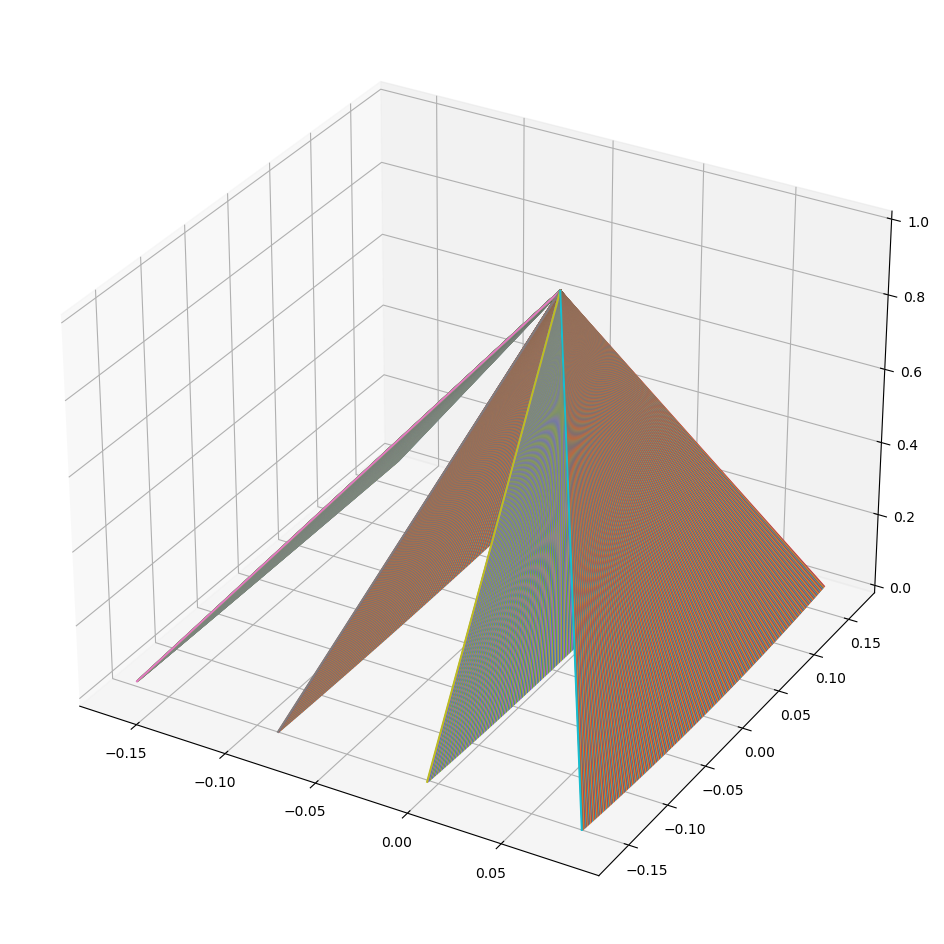

In [37]:
plot_rays(rays_o, rays_d, 1)

In [38]:
class Sphere():
    
    def __init__(self, p, r, c): #postion, radius, color of the sphere
        self.p = p
        self.r = r
        self.c = c
        
    def intersect(self, o, d): #(o: origin, d: direction)
        
        # Solve equation at^2 + bt + c = 0
        # (ox + t * dx  - xc)^2 + (oy + t * dy-yc)^2 + (oz + t * dz-zc)^2 = r^2 



        #eqn of sphere
        # (x - xc)^2 + (y - yc)^2 + (z - zc)^2 = r^2
        # x, y and z are the intersection point of the ray and the sphere
        # xc, yc and zc are the position of the sphere
        # so (x - xc)^2 + (y - yc)^2 + (z - zc)^2 = r^2 can be written as
        # (ox + t * dx  - xc)^2 + (oy + t * dy - yc)^2 + (oz + t * dz - zc)^2 = r^2 
 
        a = d[:, 0]**2 + d[:, 1]**2 + d[:, 2]**2 # is the square of the length of the vector
        # dx^2 + dy^2 + dz^2 but here d1 = d[:, 0] and d2 = d[:, 1] and d3 = d[:, 2]
        b = 2 * ((d[:, 0] * (o[:, 0] - self.p[0])) + (d[:, 1] * (o[:, 1] - self.p[1])) + (d[:, 2] * (o[:, 2] - self.p[2])))
        c = (o[:, 0] - self.p[0])**2 + (o[:, 1] - self.p[1])**2 + (o[:, 2] - self.p[2])**2 - self.r**2
        
        pho = b**2 - 4 * a * c
        cond = pho >= 0 #condition that will tell us if there is an intersection or not
        # or basically if there is a color or not
        
        num_rays = o.shape[0]
        colors = np.zeros((num_rays, 3))
        colors[cond] = self.c
        
        return colors

In [46]:
s = Sphere(np.array([0., 0., -1.]), .1, np.array([1., 0., 0.]))
# here position is 0 0 -1 and radius is 0.1 and color is 1 0 0 (red channel)

img = s.intersect(rays_o, rays_d)

In [47]:
img.shape

(160000, 3)

In [43]:
img = img.reshape(H, W, 3)


In [44]:
img.shape

(400, 400, 3)

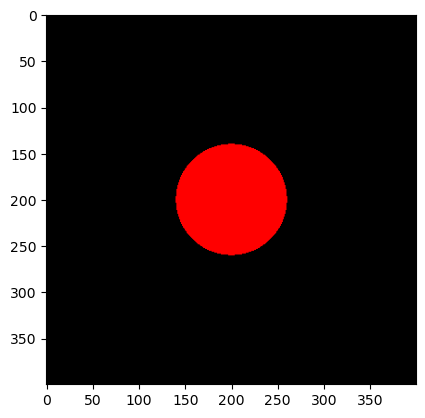

In [45]:

plt.figure()
plt.imshow(img)
plt.show()